In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
from dataset import *
random_state = 1
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = get_bike_share(random_state)

## Compare with EBM

## Train GAMI-Net 

In [3]:
%%time
model = GAMINetRegressor(interact_num=10,
                         meta_info=meta_info,
                         subnet_size_main_effect=[20],
                         subnet_size_interaction=[20, 20], 
                         max_epochs=[1000, 1000, 1000],
                         learning_rates=[0.001, 0.001, 0.001],
                         early_stop_thres=["auto", "auto", "auto"],
                         batch_size=1000,
                         reg_clarity=0.1,
                         loss_threshold=0.01,
                         normalize=True,
                         warm_start=True,
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:    1, train loss: 0.01551, validation loss: 0.01476: 100%|██████████| 12/12 [00:00<00:00, 191.11it/s]           
Epoch:    2, train loss: 0.01532, validation loss: 0.01472: 100%|██████████| 12/12 [00:00<00:00, 222.98it/s]           
Epoch:    3, train loss: 0.01528, validation loss: 0.01469: 100%|██████████| 12/12 [00:00<00:00, 200.67it/s]           
Epoch:    4, train loss: 0.01525, validation loss: 0.01469: 100%|██████████| 12/12 [00:00<00:00, 231.54it/s]           
Epoch:    5, train loss: 0.01523, validation loss: 0.01466: 100%|██████████| 12/12 [00:00<00:00, 191.11it/s]           
Epoch:    6, train loss: 0.01522, validation loss: 0.01468: 100%|██████████| 12/12 [00:00<00:00, 197.38it/s]           
Epoch:    7, train loss: 0.01524, validation loss: 0.01468: 100%|██████████| 12/12 [00:00<00:00, 182.43it/s]           
Epoch:    8, train loss: 0.01520, validation loss: 0.01468: 100%|██████████| 12/12 [00:00<00:00, 222.96it/s]           
Epoch:    9, train loss: 0.01520, valida

Main Effect Training Stop at Epoch: 50, train loss: 0.01509, validation loss: 0.01466
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:    1, train loss: 0.00643, validation loss: 0.00577: 100%|██████████| 12/12 [00:00<00:00, 58.73it/s]            
Epoch:    2, train loss: 0.00609, validation loss: 0.00566: 100%|██████████| 12/12 [00:00<00:00, 63.47it/s]            
Epoch:    3, train loss: 0.00599, validation loss: 0.00564: 100%|██████████| 12/12 [00:00<00:00, 64.73it/s]            
Epoch:    4, train loss: 0.00597, validation loss: 0.00565: 100%|██████████| 12/12 [00:00<00:00, 62.54it/s]            
Epoch:    5, train loss: 0.00588, validation loss: 0.00558: 100%|██████████| 12/12 [00:00<00:00, 63.75it/s]            
Epoch:    6, train loss: 0.00590, validation loss: 0.00552: 100%|██████████| 12/12 [00:00<00:00, 61.74it/s]            
Epoch:    7, train loss: 0.00585, validation loss: 0.00559: 100%|██████████| 12/12 [00:00<00:00, 62.71it/s]            
Epoch:    8, train loss: 0.00583, validation loss: 0.00555: 100%|██████████| 12/12 [00:00<00:00, 54.73it/s]            
Epoch:    9, train loss: 0.00577, valida

Interaction Training Stop at Epoch: 38, train loss: 0.00549, validation loss: 0.00535
#########################Stage 3: Fine Tuning#########################


Epoch:    1, train loss: 0.00605, validation loss: 0.00545: 100%|██████████| 12/12 [00:00<00:00, 32.81it/s]            
Epoch:    2, train loss: 0.00553, validation loss: 0.00533: 100%|██████████| 12/12 [00:00<00:00, 35.41it/s]            
Epoch:    3, train loss: 0.00546, validation loss: 0.00534: 100%|██████████| 12/12 [00:00<00:00, 32.80it/s]            
Epoch:    4, train loss: 0.00543, validation loss: 0.00530: 100%|██████████| 12/12 [00:00<00:00, 38.38it/s]            
Epoch:    5, train loss: 0.00541, validation loss: 0.00531: 100%|██████████| 12/12 [00:00<00:00, 41.09it/s]            
Epoch:    6, train loss: 0.00543, validation loss: 0.00531: 100%|██████████| 12/12 [00:00<00:00, 42.25it/s]            
Epoch:    7, train loss: 0.00542, validation loss: 0.00532: 100%|██████████| 12/12 [00:00<00:00, 42.85it/s]            
Epoch:    8, train loss: 0.00541, validation loss: 0.00538: 100%|██████████| 12/12 [00:00<00:00, 42.54it/s]            
Epoch:    9, train loss: 0.00549, valida

Fine Tuning Stop at Epoch: 11, train loss: 0.00542, validation loss: 0.00532
Wall time: 27 s


In [4]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[71.54836 74.2572 ]


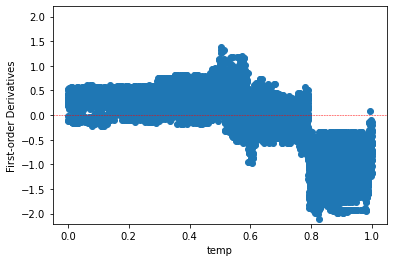

In [5]:
model.partial_derivatives(6)

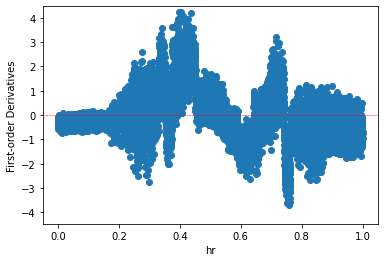

In [6]:
model.partial_derivatives(2)

In [7]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [8]:
model.get_clarity_loss(test_x)

0.0007398392772302032

## Visualization

In [9]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

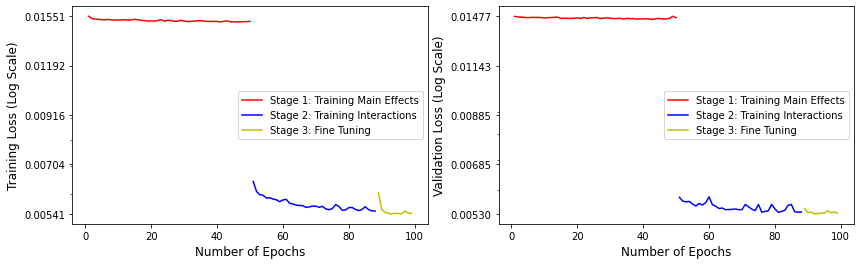

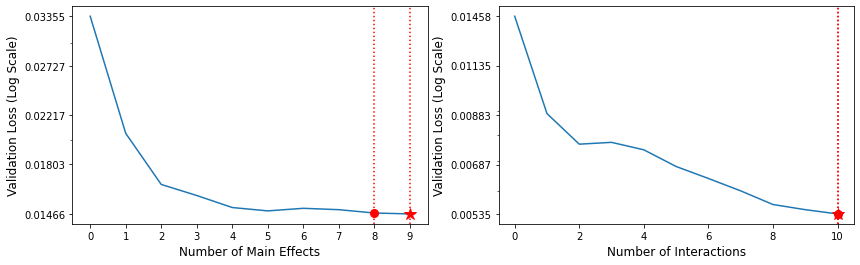

In [10]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

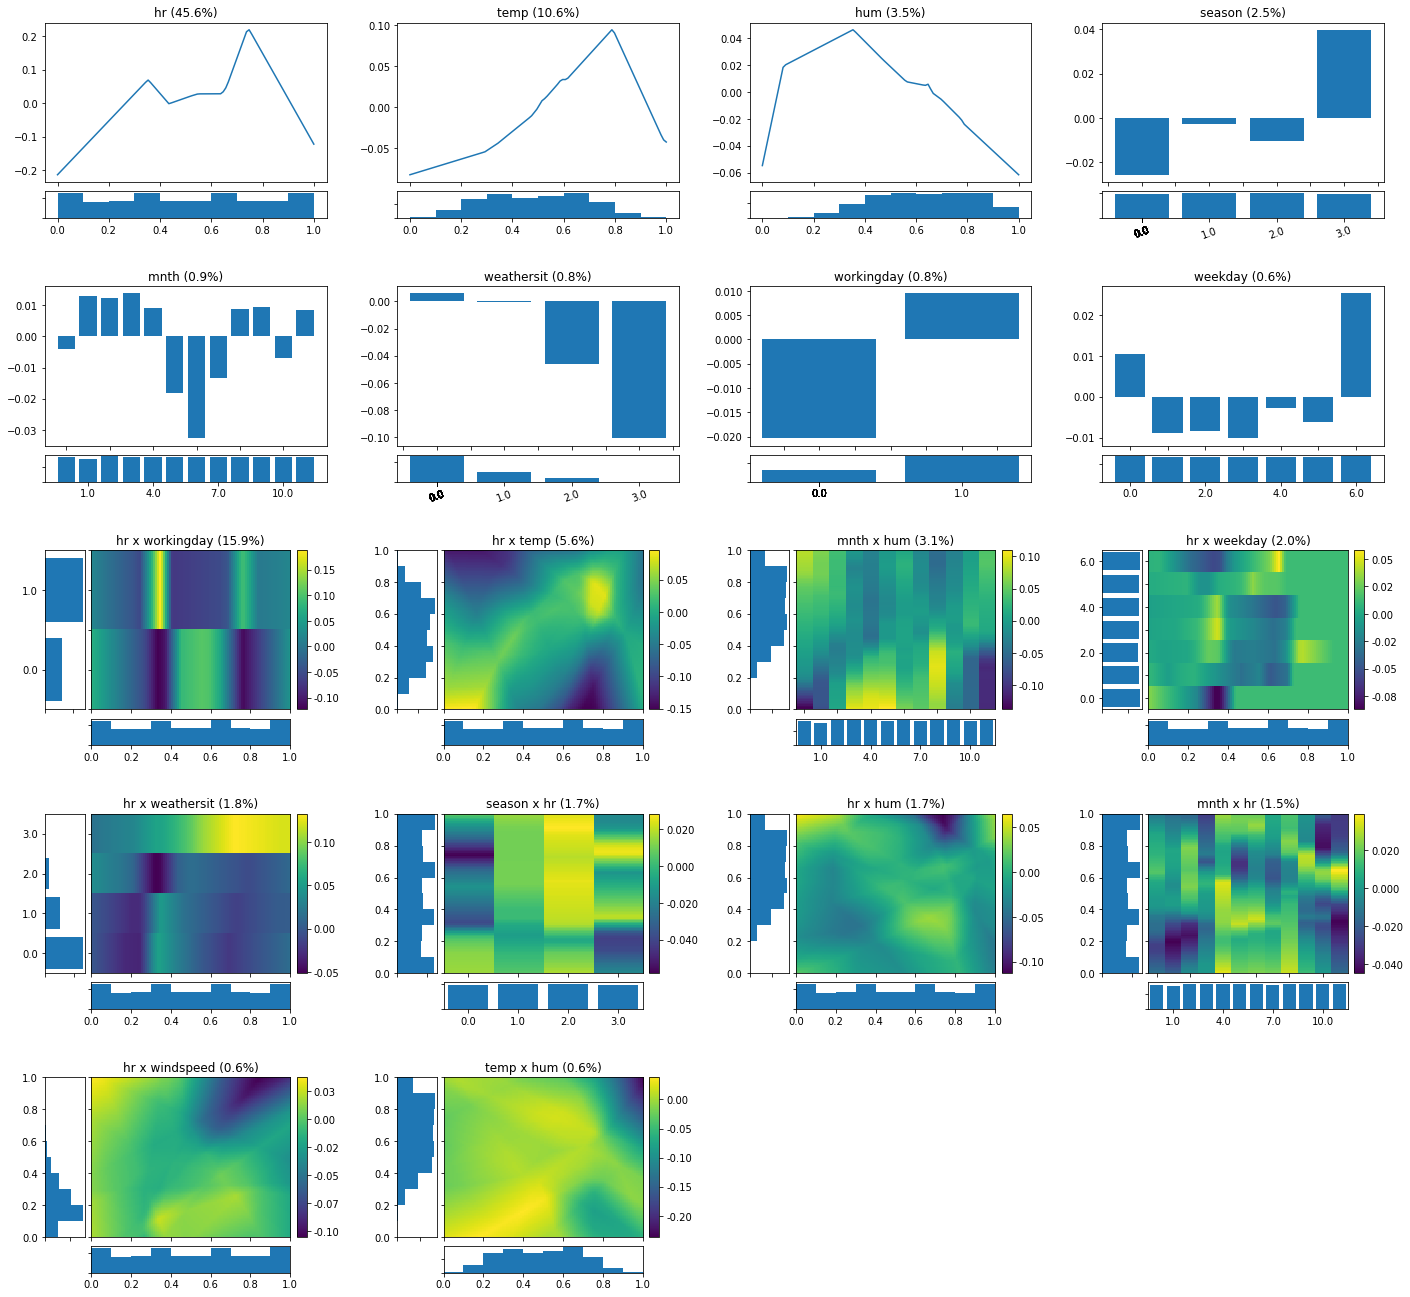

In [11]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=10, interaction_num=10, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

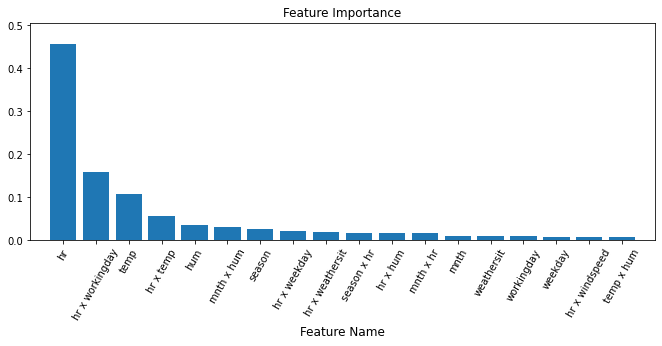

In [12]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [13]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

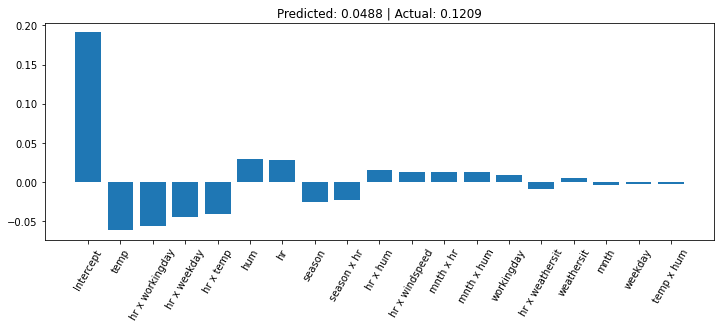

In [14]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [15]:
model.save(name="simu")
modelnew = GAMINetRegressor()
modelnew.load(name="simu")
modelnew.predict(train_x)

array([[ 0.04880228],
       [ 0.10676962],
       [ 0.00727237],
       ...,
       [ 0.17181484],
       [ 0.17574748],
       [-0.01391309]], dtype=float32)